# Comparación del algoritmo Lista de Clusters frente a otros

Esta notebook pretende comparar el algoritmo de **Lista de Clusters** con algoritmos de clustering normalmente utilizados en el aprendizaje automatico. El objetivo es mostrar las características de diferentes algoritmos de clustering en conjuntos de datos que son "interesantes" pero aún en 2D. Si bien estos ejemplos dan cierta intuición acerca de los algoritmos, esta intuición podría no aplicarse a datos dimensionales muy elevados.

## Importamos las librerías necesarias
Si vamos a comparar algoritmos de agrupamiento, necesitaremos algunas cosas; primero algunas bibliotecas para cargar y agrupar los datos, y en segundo lugar algunas herramientas de visualización para que podamos ver los resultados de la agrupación.

In [1]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import hdbscan
from list_of_clusters import ListOfClusters

%matplotlib inline

np.random.seed(0)
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

## Generamos los distintos conjuntos de datos para comparar

In [2]:
def make_var_density_blobs(n_samples=750, centers=[[0,0]], cluster_std=[0.5]):
    samples_per_blob = n_samples // len(centers)
    blobs = [datasets.make_blobs(n_samples=samples_per_blob, centers=[c],
                                 cluster_std=cluster_std[i])[0]
             for i, c in enumerate(centers)]
    labels = [i * np.ones(samples_per_blob) for i in range(len(centers))]
    return np.vstack(blobs), np.hstack(labels)

# Elegimos el tamaño lo suficientemente grande como para ver la
# escalabilidad de los algoritmos, pero no demasiado grande para
# evitar tiempos de ejecución demasiado largos.
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.055)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.065)
blobs = datasets.make_blobs(n_samples=n_samples-200, random_state=8)
noisy_blobs = np.vstack((blobs[0], 25.0*np.random.rand(200, 2)-[10.0,10.0])),\
            np.hstack((blobs[1], -1*np.ones(200)))
varying_blobs = make_var_density_blobs(n_samples,
                                       centers=[[1, 1],
                                                [-1, -1],
                                                [1, -1]],
                                       cluster_std=[0.2, 0.35, 0.5])

# Aplicamos transformación a blobs
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

no_structure = np.random.rand(n_samples, 2), None
easy_blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Definimos los parámetros para cada algoritmo dado cada conjunto de datos.
default_base = {'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'center_choise':'p1',
                'fixed_size': None,
                'fixed_radius': 1.0,
                'distance_metric':'euclidean'}
clustering_datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,'n_clusters': 2,
                     'fixed_size': 750, 'center_choise':'p1'}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2,
                   'fixed_radius': 1.75, 'center_choise':'p3'}),
    (noisy_blobs, {'fixed_size': 500, 'center_choise':'p1'}),
    (varying_blobs, {'fixed_radius': 1.4, 'center_choise':'p1'}),
    (aniso, {'eps': .15, 'n_neighbors': 2, 'fixed_size': 500,
             'center_choise':'p4', 'distance_metric':'cityblock'}),
    (easy_blobs,{'fixed_size': 500, 'center_choise':'p3'}),
    (no_structure, {})]

clustering_names = [
    'KMeans', 'AffinityPropagation',
    'SpectralClustering', 'AgglomerativeClustering',
    'GaussianMixture', 'DBSCAN', 'HDBSCAN', 'ListOfClusters']

## Graficamos los grupos generados por cada algoritmo.

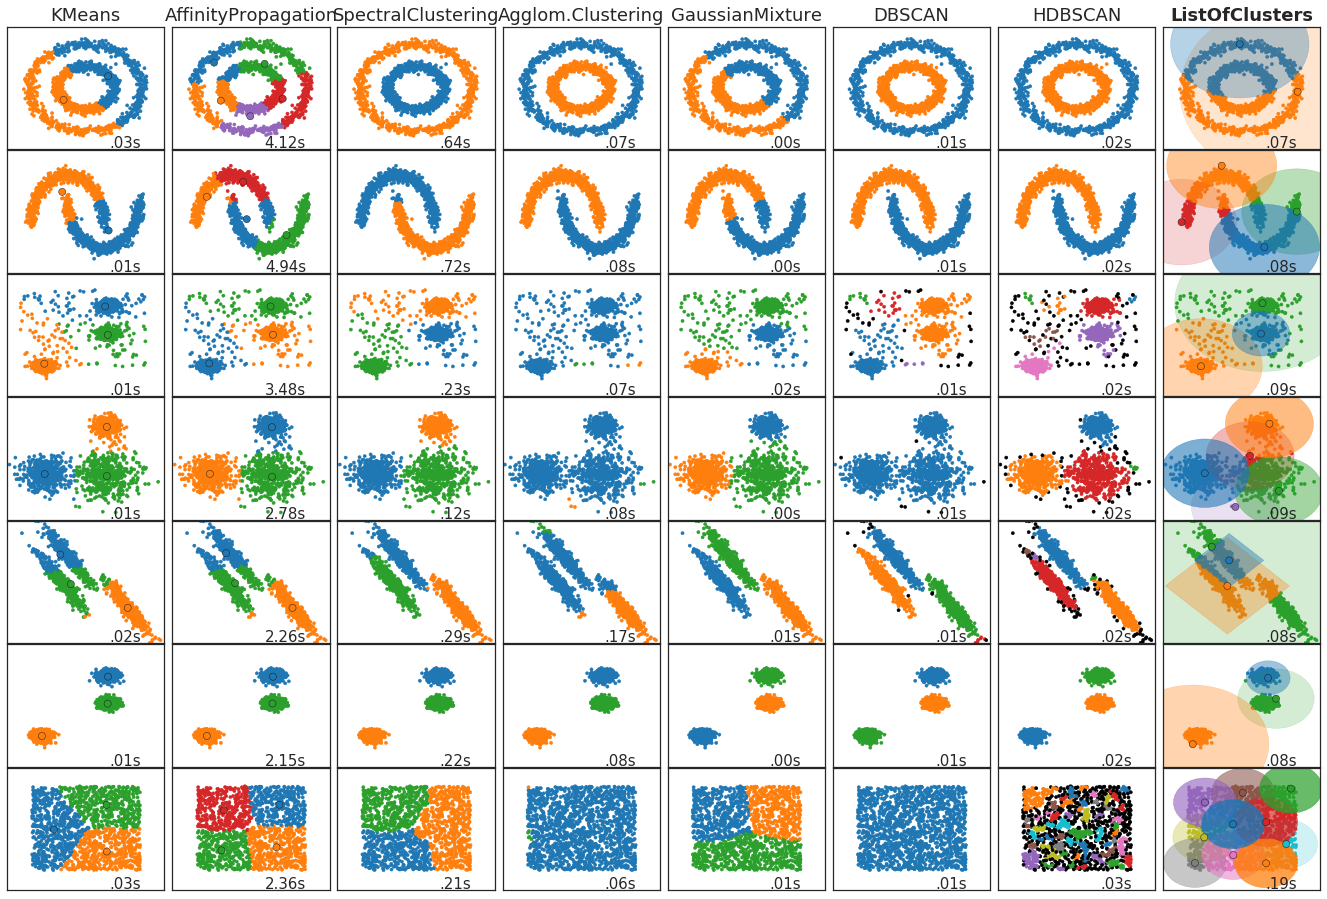

In [3]:
# https://matplotlib.org/examples/color/colormaps_reference.html
my_palette = 'tab10'

plt.figure(figsize=(len(clustering_names) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(clustering_datasets):
    # Actualizamos los parametros con los valores específicos para cada dataset
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    # Normalizamos el dataset para una selección de parámetros más sencilla.
    # Estandarizamos las características removiendo la media y
    # escalando a varianza unitaria.
    X = StandardScaler().fit_transform(X)

    # Matriz de conectividad para Ward estructurado.
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'],
                                    include_self=False)
    # Contruir la conectividad simétrica.
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Creamos los estimadores para la tarea de clustering.
    two_means = cluster.KMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'],
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation =\
        cluster.AffinityPropagation(damping=params['damping'],
                                    preference=params['preference'])
    average_linkage = \
        cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",
                                        n_clusters=params['n_clusters'],
                                        connectivity=connectivity)
    hdbscanner = hdbscan.HDBSCAN()
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    lc = ListOfClusters(center_choise=params['center_choise'],
                        fixed_radius=params['fixed_radius'],
                        fixed_size=params['fixed_size'],
                        distance_metric=params['distance_metric'])
     
    clustering_algorithms = (
        ('KMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('SpectralClustering', spectral),
        ('Agglom.Clustering', average_linkage),
        ('GaussianMixture', gmm),
        ('DBSCAN', dbscan),
        ('HDBSCAN', hdbscanner),
        ('ListOfClusters', lc)
    )
    
    for name, algorithm in clustering_algorithms:
        # Predecimos la pertenencia a clusters.
        t0 = time.time()
        
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            
            algorithm.fit(X)
        
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # Graficamos
        ax = plt.subplot(len(clustering_datasets), len(clustering_algorithms),
                         plot_num)
        if i_dataset == 0:
            if name == 'ListOfClusters':
                plt.title(name, size=18, weight='bold')
            else:
                plt.title(name, size=18)
        
        palette = sns.color_palette(my_palette, np.unique(y_pred).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in y_pred]
        
        plt.scatter(X[:, 0], X[:, 1], color=colors, s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            # Invertimos el orden de los centros y sus colores para que
            # el primer centro obtenido quede en frente al graficar.
            centers = np.flip(algorithm.cluster_centers_, 0)
            center_colors = list(reversed(palette[:len(centers)]))
            plt.scatter(centers[:, 0], centers[:, 1], s=50, c=center_colors,\
                        edgecolors='k', zorder=3)

            if (hasattr(algorithm, 'cluster_radius_')):
                neg_alpha = 0.65

                # Invertimos al igual que con los centros y sus colores para
                # el caso de los radios y sus colores.
                radius = list(reversed(algorithm.cluster_radius_))
                cluster_colors = list(reversed(palette[:len(radius)]))

                for pos, r in enumerate(radius):
                    if algorithm.distance_metric == 'euclidean':
                        circle = plt.Circle((centers[pos][0],centers[pos][1]),
                                            r, color=cluster_colors[pos],
                                            alpha=0.85-neg_alpha, zorder=1)
                        ax.add_artist(circle)
                    elif algorithm.distance_metric == 'cityblock':
                        diagonal = 2*r
                        l = diagonal / (2**0.5)
                        rec_x = centers[pos][0]
                        rec_y = centers[pos][1] - r
                        rect = patches.Rectangle(xy=(rec_x, rec_y),
                                                 width=l, height=l,
                                                 zorder=1, angle=45,
                                                 color=cluster_colors[pos],
                                                 alpha=0.85-neg_alpha)
                        ax.add_patch(rect)
                    neg_alpha = neg_alpha * 0.80
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.85, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()